In [11]:
# -*- coding: utf-8 -*-
"""
Created on Sat May 28 20:07:32 2022

@author: ibro
"""
import random
import pygame
import time
import math
from math import exp, sqrt
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
################################################


nr_blob_eaten_global=0
nr_apple_eaten_global=0
#################################################
"""  General fucntion """
def distance(x1, y1, x2, y2):
    return sqrt( (x2-x1)**2 + (y2-y1)**2)

def get_obj_size(world, obj_class):
    return len([obj for obj in world if isinstance(obj, obj_class)])

def get_population_sizes(world, obj_types):
    populations = dict()
    for obj in obj_types.keys():
        populations[obj] = get_obj_size(world, obj)        
    return populations

def is_close(x1, y1, x2, y2, Vision_range):
    Distance = distance(x1, y1, x2, y2)
    if Distance <= Vision_range:
        return True
    return False
def energy_reDistibution(percentage):
    # 0.2 0.5
    portion1 = random.uniform(0,1)
    portion2 = random.uniform(portion1, 1)
    
    portion3 = 1 - portion2   
    portion2 -= portion1
    print(portion1+portion2 + portion3)
    return percentage * np.array([portion1, portion2, portion3])
#################################################
class Objects(pygame.sprite.Sprite):
    def __init__(self, world, coord):
        super(Objects, self).__init__()
        pygame.sprite.Sprite.__init__(self)
        self.world = world
        self.birth_place = coord
        
    def generate_object(self, object_type, size):
        #self.Typo = object_type
        self.x = self.birth_place[0]
        self.y = self.birth_place[1]
        self.size = size
        self.width = int(self.size[0] * self.world.proportion )
        self.height = int(self.size[1] * self.world.proportion )
        
        image = f"images/{object_type}.png"
        self.Image0 = pygame.image.load(image)
        self.Image = pygame.transform.scale(self.Image0, (self.width, self.height))
        self.rect = pygame.rect.Rect((self.x, self.y, self.width, self.height))
        self.rect.center = (self.x, self.y)
        
    def is_eaten_from(self, obj):
        obj.survive = True
        obj.score +=1
        self.alive = False
        global nr_blob_eaten_global, nr_apple_eaten_global
        if self.type=="Blob":
            nr_blob_eaten_global+=1
        if self.type=="Apple":
            nr_apple_eaten_global+=1
        
    def check_energy(self):
        if self.energy <= 0:
            #self.alive = False
            self.immobile = True
            
    def get_position(self):
        return self.x, self.y

class Blob(Objects):# has World class as an input and the coordinate of the object in that world
    def __init__(self, world, coord ):
        super(Blob,self).__init__(world, coord)
        self.type = "Blob"
        self.initial_energy = 2000#10000->2000
        self.energy = self.initial_energy
        #self.energy_lose = 10
        
        #self.size_scaling = self.energy_lose# max 10
        #self.speed_scaling = 0.2*self.energy_lose# max 2
        #self.vision_scaling = 10*self.energy_lose# max 100
    
        
        self.Size = 1#0.1 * self.size_scaling# the first part is portion of energy and the second part is scaling
        self.speed = 1#0.7 * self.speed_scaling# the first part is portion of energy and the second part is scaling
        self.vision = 20#0.2 * self.vision_scaling# the first part is portion of energy and the second part is scaling
        self.energy_lose = self.Size**3 * self.speed**2 + self.vision/20# = 2
       # self.increment = 0.1
        self.size_blob = ( 160, 240) # this for window size
        self.world = world
        
        
        self.alive = True
        self.survive = False
        self.attention = False
        self.immobile = False
        
       # self.mutation = 0.2
       # self.mutation_probability = 0.1
        self.attention_spot = random_attention()
        #print(world.world_height*random.uniform(0,1))
        self.attention_spot.x = self.world.world_width*random.uniform(0,1)
        self.attention_spot.y = self.world.world_height*random.uniform(0,1)
        self.obj_attention = {"food":None, "enemy":None}
        self.generate_object(self.type, self.size_blob)
        
        self.score = 0
        
   # def activate(self):
        
    def update(self, world, objs):
        neighbors = self.neighbors(objs)
        self.update_blob()
        self.check_energy()#ADDED
        if self.score < 2:
            self.act(neighbors)
            self.check_encounter(world, objs)
        else:
            self.go_home()
        
        self.check_energy()
       
        
    def neighbors(self, objs):
        return [obj for obj in objs if distance(self.x, self.y, obj.x, obj.y) <=self.vision and id(self)!=id(obj)]
    
    def update_blob(self):
        self.attention = False
        self.update_sight()
        self.explore() if random.random() <= 0.0001 else None
        self.energy -= self.energy_lose
        #if self.score == 0:
        #    self.energy -= self.energy_lose
        
    def explore(self):
        self.attention_spot.x = self.world.world_width *random.uniform(0,1)
        self.attention_spot.y = self.world.world_height *random.uniform(0,1)
        
    def act(self, objs):
        obj_distance = {"enemy": math.inf, "food": math.inf}
        flag = 0
        
        for obj in objs:
            dist = distance(self.x, self.y, obj.x, obj.y)
            in_sight = dist <= self.vision
            
            if in_sight:
                if isinstance(obj, Blob):
                 
                    obj_is_enemy = obj.Size/self.Size >=1.2
                    obj_is_food = self.Size/obj.Size >= 1.2
                    if obj_is_enemy and dist<=obj_distance["enemy"] and id(self)!=id(obj):
                    
                        obj_distance["enemy"] = dist
                        self.attention_on(obj, "enemy")
                        flag += 1
                        
                    
                    elif obj_is_food and dist <= obj_distance["food"] and id(self)!=id(obj):
                      
                        obj_distance["food"] = dist
                        self.attention_on(obj, "food")
                        flag += 1
                
                elif isinstance(obj, Apple) and dist <= obj_distance["food"] and id(self)!=id(obj):
                  
                    obj_distance["food"] = dist
                    self.attention_on(obj, "food")
                    flag += 1
                    
        
        if flag:
            if obj_distance["enemy"] <= obj_distance["food"]:
                location = self.obj_attention["enemy"]
                if location is not None:
                    self.attention_spot.x = location[0]
                    self.attention_spot.y = location[1]
                    self.reverse_direction()
                    
            elif obj_distance["food"] < obj_distance["enemy"]:
                location = self.obj_attention["food"]
                if location is not None:
                    self.attention_spot.x = location[0]
                    self.attention_spot.y = location[1]
        else:
            if np.sqrt((self.attention_spot.x-self.x)**2 + (self.attention_spot.y - self.y)**2) < 10:
                self.explore()
            
        if self.immobile==False:
            self.move()
        
                    
    def attention_on(self, obj, Type):
        self.obj_attention[Type] = (obj.x, obj.y)
        self.attention = True
        
    def reverse_direction(self):
        self.attention_spot.x = self.x + (self.x - self.attention_spot.x)
        self.attention_spot.y = self.y + (self.y - self.attention_spot.y)
        
    def attention_direction(self):
        d = np.subtract((self.attention_spot.x, self.attention_spot.y),(self.x, self.y))
        d = d/np.linalg.norm(d)
        return d*self.speed
    
    def go_home(self):
        self.attention_spot.x = self.birth_place[0]
        self.attention_spot.y = self.birth_place[1]
        if self.immobile==False:
            self.move()
        
    def move(self):
        dx = self.attention_direction()[0]
        dy = self.attention_direction()[1]
        
        self.x = (dx + self.x)#%self.world.world_width
        self.y = (dy + self.y)#%self.world.world_height
        if self.x >= self.world.world_width:
            self.x -= 2*dx
            self.reverse_direction()
        if self.y >= self.world.world_height:
            self.y -= 2*dy
            self.reverse_direction()
        
        self.rect.center = (self.x, self.y)
        
    def update_sight(self):
        for obj_name in self.obj_attention.keys():
            location = self.obj_attention[obj_name]
            if location is not None and distance(self.x, self.y, location[0], location[1]) <= self.vision:
                self.obj_attention[obj_name] = None
                
    def check_encounter(self, world, objs):
        for obj in objs:
            if self.rect.colliderect(obj):
                if type(obj) is Apple:
                    obj.is_eaten_from(self)
                    
                elif type(obj) is Blob and self.Size/obj.Size >=1.2:
                    obj.is_eaten_from(self)
                    
    def reproduce(self, birth_coord):
        #example of energy redistribution
        # 0.2 0.5 -> 0.3 0.4
        # 0.2 0.3 0.5->  0.3 0.1 0.6
        #-0.1 0.2 -0.1
        #replica = Blob(self.world, (self.x, self.y - (self.width + 5)))
        #energy_percentage = 0.1
        replica = Blob(self.world, birth_coord)
        speed_mutate    = random.uniform(0.9,1.1)
        vision_mutate   = random.uniform(0.9,1.1)
        size_mutate     = random.uniform(0.9,1.1)
        #increment = energy_reDistibution(energy_percentage) - energy_reDistibution(energy_percentage)
        replica.speed = self.speed   * speed_mutate 
        replica.vision = self.vision * vision_mutate
        replica.Size  = self.Size    * size_mutate
        replica.width = self.width   * size_mutate#+ increment[2] *self.size_scaling
        replica.height = self.height * size_mutate#+ increment[2] *self.size_scaling
        
        replica.energy_lose = replica.Size**3 * replica.speed**2 + replica.vision/20

        replica.Image = pygame.transform.scale(replica.Image0, (replica.width, replica.height))
        replica.rect = pygame.rect.Rect((replica.x, replica.y, replica.width, replica.height))
        
        return replica
    
"""
energy 10

"""    

class random_attention:
    x = -1
    y = -1
    
class Apple(Objects):
    def __init__(self, world, coord):
        super(Apple, self).__init__(world, coord)
        self.type = "Apple"
        self.size_apple = (64,80)
        self.Size = 1
        self.generate_object(self.type, self.size_apple)
        self.alive = True
    def update(self):
        pass
        

class World:
    def __init__(self, world):
        self.world_width = world[0]
        self.world_height = world[1]
        self.proportion = 0.1
        self.width_num = 50
        self.height_num = 50
        self.width_PortionSize = math.ceil(self.world_width/self.width_num) # s0 500/50 is equivalent to 500/55
        self.height_PortionSize = math.ceil(self.world_height/self.height_num)
        self.blobs = Blob.__subclasses__()
        self.replicas = []
        self.birth = "boundary" # "random"
        
        self.color = []
        self.coord = 0
        self.x = 0
        self.y = 0

        #self.nr_eaten=0
        
    def generate_objects(self, object_types=None):
        self.fill_landscape()
        objects=[]
        for obj in object_types.keys():
            if obj == Apple:
                for apple in range(object_types[obj]):
                    objects.append(self.generate_apple())
            else: # if the obj == Blob
                if self.birth == "random":
                    X = self.world_width*random.random()
                    Y = self.world_height *random.random()          
                    objects += [obj(self, (X,Y) ) for i in range(object_types[obj])]
                
                elif self.birth == "boundary":
                    for i in range(object_types[obj]):
                        left_bound   = (1                                      ,       self.world_height *random.random())
                        right_bound  = (self.world_width-self.width_PortionSize,       self.world_height *random.random())
                        upper_bound  = (self.world_width *random.random()      ,                                        1)
                        lower_bound  = (self.world_width *random.random()      ,self.world_height-self.height_PortionSize)
                        boundary = [ upper_bound, lower_bound, left_bound, right_bound]
                        X_Y = random.choice(boundary)            
                        objects += [ obj(self, X_Y ) ]
            
        return objects
    
    def fill_landscape(self):
        for row in range(self.width_num):
            for col in range(self.height_num):
                self.color.append( (random.randint(75, 90), random.randint(110, 120), random.randint(40, 50)) )
                
        
    def generate_apple(self):
        return Apple(self, (self.world_width*random.random(),
                            self.world_height * random.random()))
    
    def update(self, world_objects):
        for obj in world_objects:
            if isinstance(obj, Blob):
                obj.update(self, world_objects)
            elif isinstance(obj, Apple):
                obj.update()
          
        
        world_objects = [obj for obj in world_objects if obj.alive]  
        
        """ This for to add apples with time"""
        #if random.random() <= 0.1:
        #    world_objects.append(self.generate_apple())
        """ This for to remove apples with time"""
        #if random.random() <= 0.99:
        #    world_objects.pop(self.generate_apple())

        
        world_objects += self.replicas
        #for i in range(5):
        self.replicas = []          
        return world_objects
    
    def new_day(self, world_objects, object_types ):
        world_objects = [obj for obj in world_objects if (isinstance(obj, Blob) and obj.alive and obj.survive )]
        replicas = []
        for obj in world_objects:
                
            left_bound   = (1                                      ,       self.world_height *random.random())
            right_bound  = (self.world_width-self.width_PortionSize,       self.world_height *random.random())
            upper_bound  = (self.world_width *random.random()      ,                                        1)
            lower_bound  = (self.world_width *random.random()      ,self.world_height-self.height_PortionSize)
            boundary = [ upper_bound, lower_bound, left_bound, right_bound]
            X_Y = random.choice(boundary)
            if obj.score == 2:
                replica = obj.reproduce(random.choice(boundary))
                replicas.append(replica)
            obj.x = X_Y[0]
            obj.y = X_Y[1]
            obj.energy = obj.initial_energy
            obj.score = 0
            obj.attention = False
            obj.survive = False
            obj.immobile=False
            
        if random.random()<=0.1:
            object_types[Apple]-=1    
        for apple in range(object_types[Apple]):
            world_objects.append(self.generate_apple())
                
                                   
        
        return world_objects + replicas
            
    
            
        
                    
class EcoSystem:
    def __init__(self, world_width, world_height):
        self.w = world_width
        self.h = world_height
        super(EcoSystem,self).__init__()
        num_apples = 20
        num_blobs = 10
        self.object_types = {Apple: num_apples, Blob: num_blobs}
        
        self.eco_system = None
       # self.popSize_time = dict()
        self.iteration = 0
        self.past_size = 0
        self.system_objects = None
        
        self.stop = time.time()
        self.last_time = time.time()

        #self.nr_eaten = 0
        
        self.activate()
        
    def activate(self):
        self.eco_system = World((self.w, self.h))
        self.system_objects = self.eco_system.generate_objects(object_types=self.object_types)
        self.past_size = len(self.system_objects)
        
    def update(self,iterations):
        one_day_passed = ((iterations+1) %1000 == 0)
        #eco_system is a world with object and updating the system implies updating the objects of its world
        if one_day_passed:
            self.system_objects = self.eco_system.new_day(self.system_objects,object_types=self.object_types)
            
            #self.system_objects = self.eco_system.update(self.system_objects)
        else:
            self.system_objects = self.eco_system.update(self.system_objects)
            

In [12]:
"""
Parameter Review:
    -Day: is 1000 iteration
    -start population: blubs: 10, apples 20
    -initial energy is 800
    -energy lose = 1 => every blob can spend 80% of the day way scorching for food before it is home gain otherwise it dies
    -each blob can eat blobs that half the size and avoid the blobs that double the size
    -the size increase only with mutation however it can be made as a function of food intake
    -vision range in 10 and it changes only with mutation
    -mutation is invitabley every generation, however it can be given a probability
    -initial configuration 10 blobs and 20 apples. Apples are constant and renewed every day
    - size is inversely proportionate to speed
    summary:
        each blob start from the boundary scorching for food and losses energy every time step
        if the blob get to eat one food item, then it ensures survival to the next day
        if the blob runs out of energy before getting food, it dies
        and it stop losing energy in this particular day. Thus, after eating one food item
        the blob continue walking freely for the second food item that ensures reproduction
        if the blob gets the second item, it goes home 
        in the next day, only blobs that got two items get replicated
        in the replication, the mutation occurs
"""
       

world_width, world_height = (500,500)#window.get_size()

display_world = True
nr_blob_eaten_global=0
nr_apple_eaten_global=0
run_name="runtmp"
blob_world = EcoSystem(world_width, world_height)
iteration = 0
size = []
speed= []
vision=[]
apples_eaten=[]
blobs_eaten=[]
total_days=100
total_iterations=total_days*1000
pbar = tqdm(total = total_days)
while iteration<total_iterations:
    if iteration%1000==0:
        size_tmp=np.array([])
        speed_tmp=np.array([])
        vision_tmp=np.array([])
        for obj in blob_world.system_objects:
            if isinstance(obj, Blob):
                size_tmp = np.append(size_tmp,obj.Size)
                speed_tmp = np.append(speed_tmp,obj.speed)
                vision_tmp = np.append(vision_tmp,obj.vision)
        size.append(size_tmp)
        speed.append(speed_tmp)
        vision.append(vision_tmp)
        apples_eaten.append(nr_apple_eaten_global)
        blobs_eaten.append(nr_blob_eaten_global)
        pbar.update(1)
    blob_world.update(iteration)
    Day = "Day: "+ f"{int(iteration/1000 + 1)}"
    iteration += 1
    

 12%|█▏        | 12/100 [00:06<00:50,  1.75it/s]/var/folders/gj/b_6qbpf106vgb2f614dhqxt40000gn/T/ipykernel_52157/86017479.py:220: RuntimeWarning: invalid value encountered in true_divide
  d = d/np.linalg.norm(d)
100%|██████████| 100/100 [00:27<00:00,  7.13it/s]

/var/folders/gj/b_6qbpf106vgb2f614dhqxt40000gn/T/ipykernel_52157/460880864.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


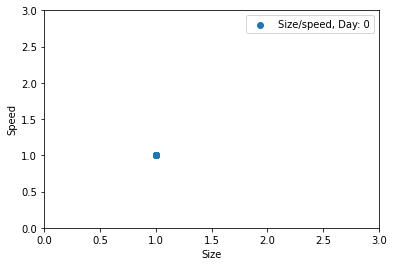

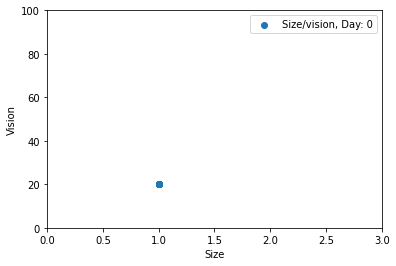

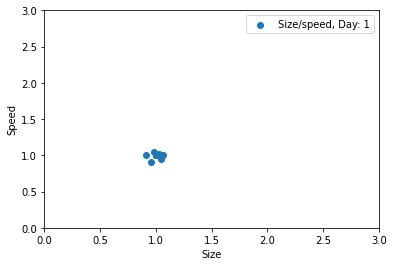

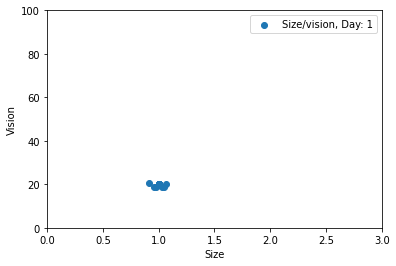

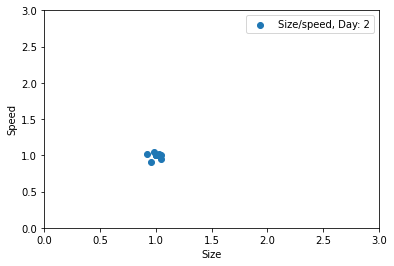

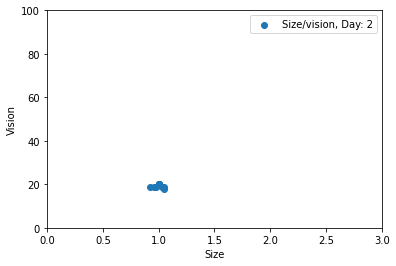

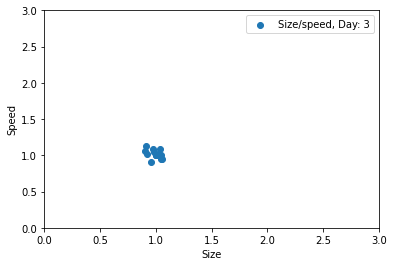

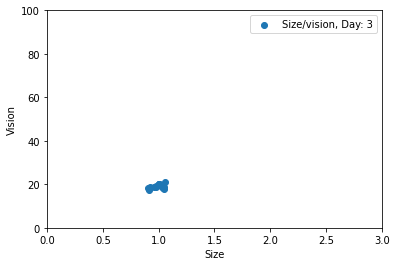

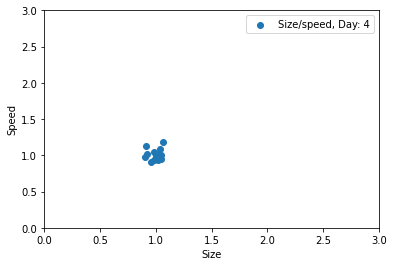

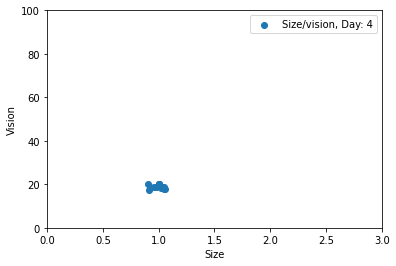

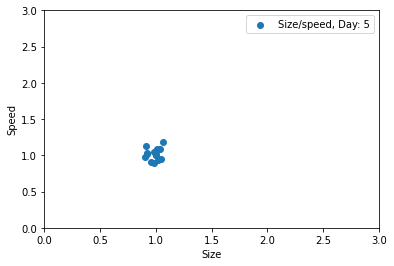

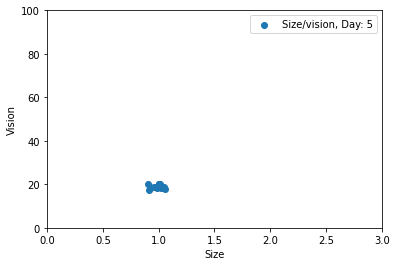

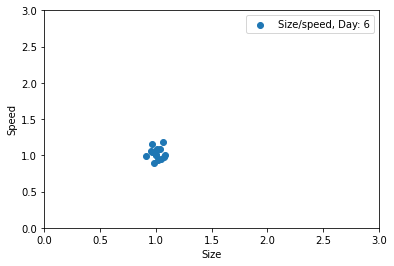

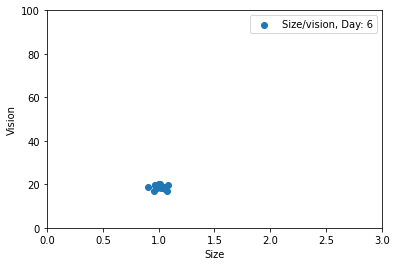

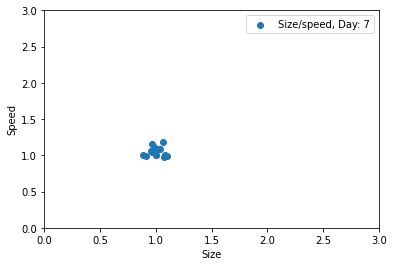

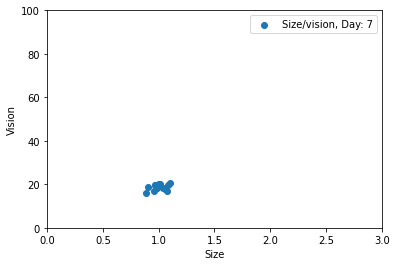

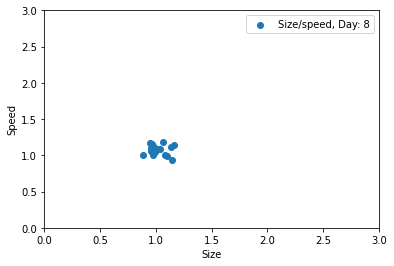

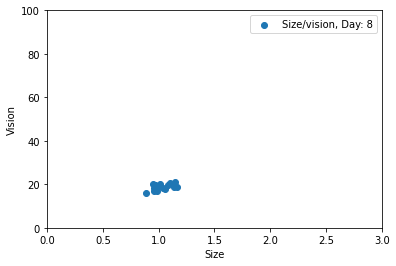

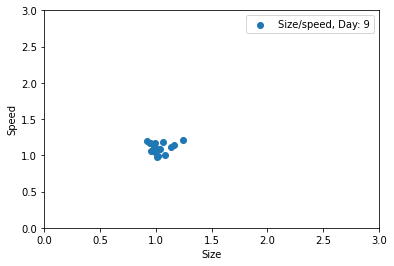

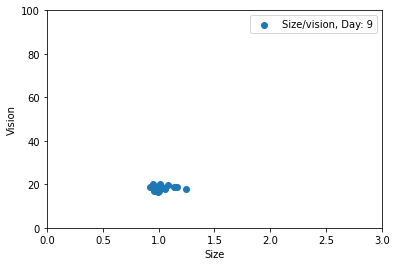

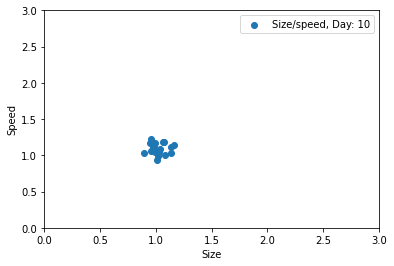

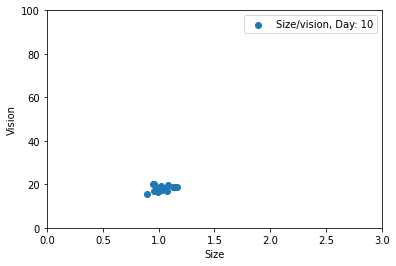

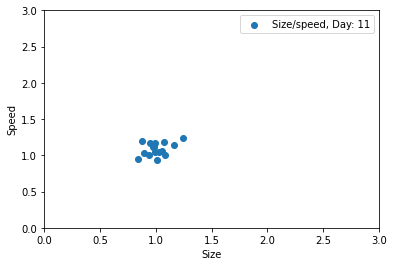

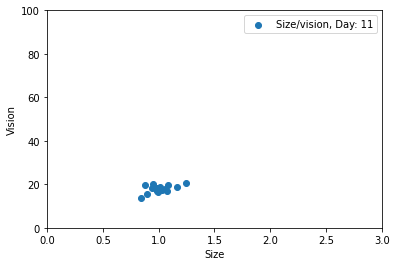

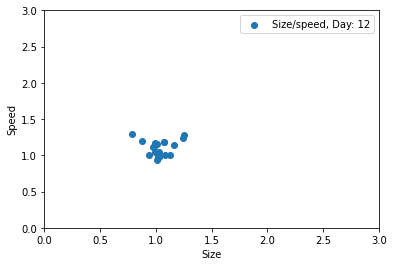

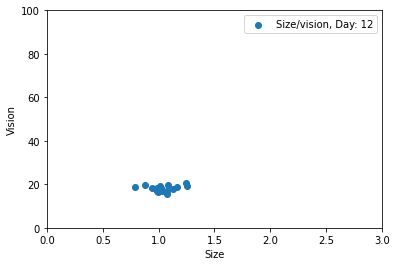

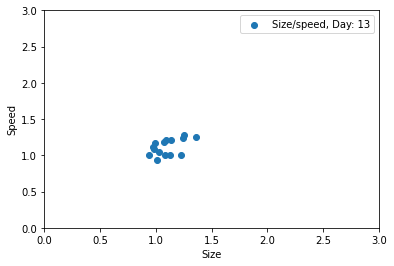

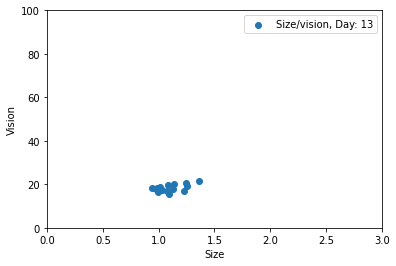

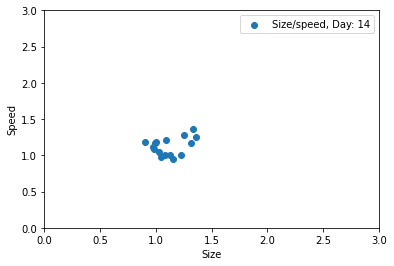

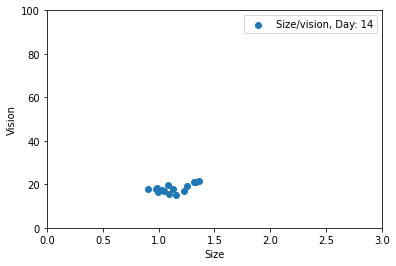

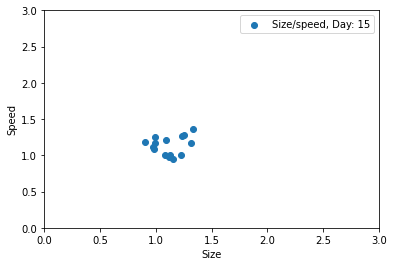

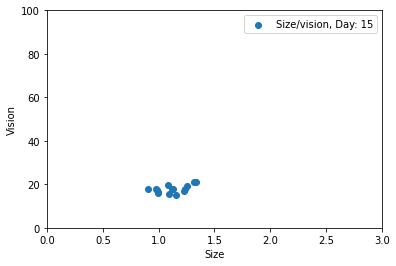

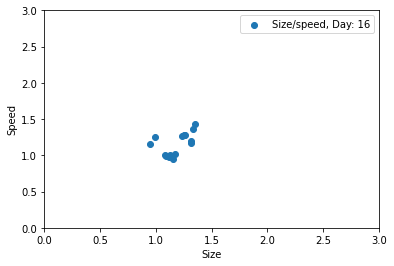

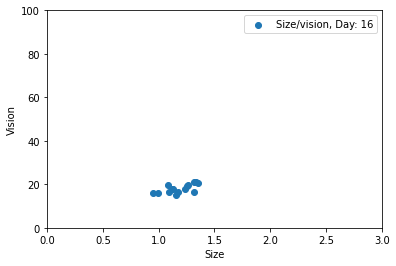

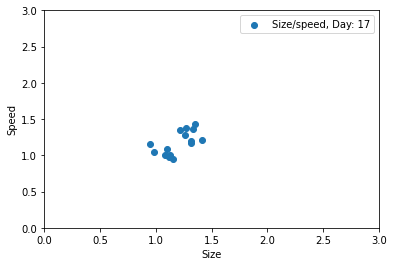

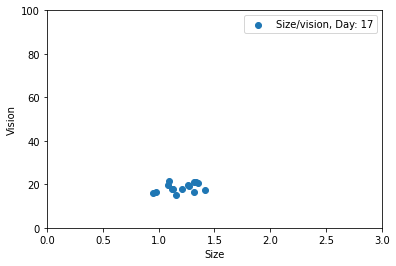

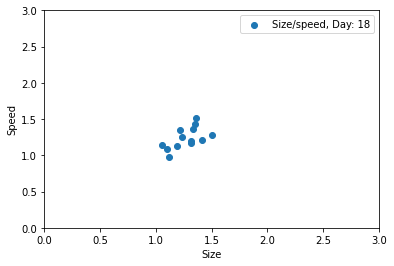

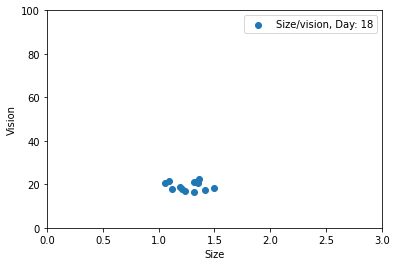

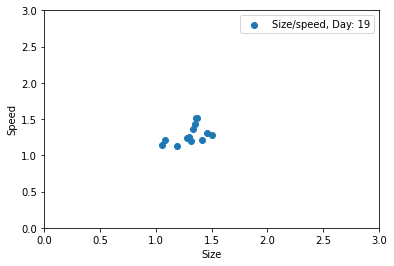

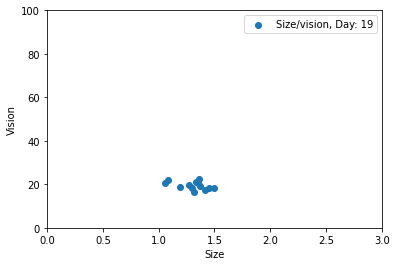

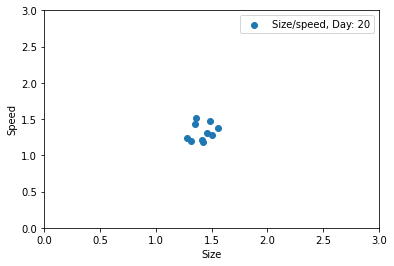

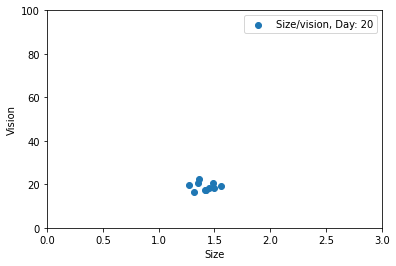

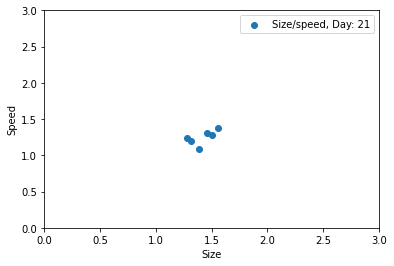

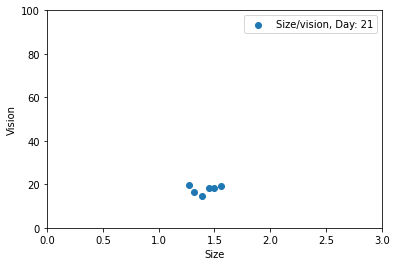

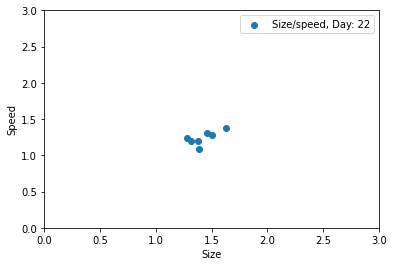

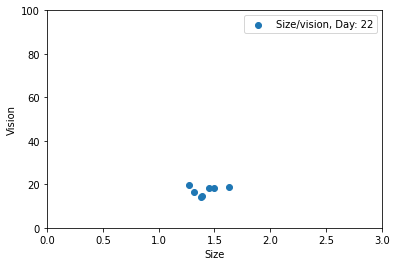

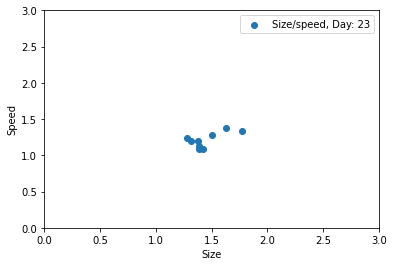

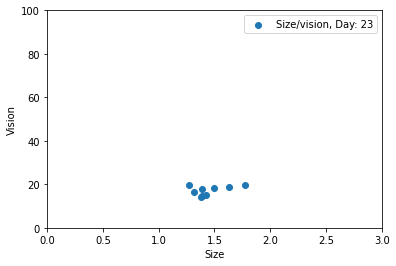

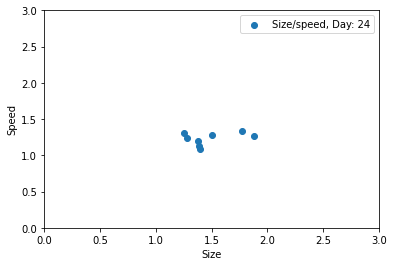

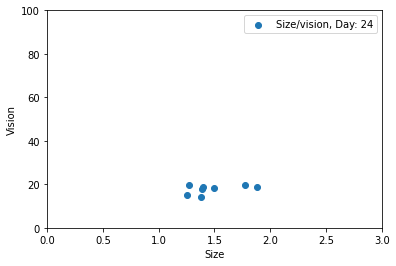

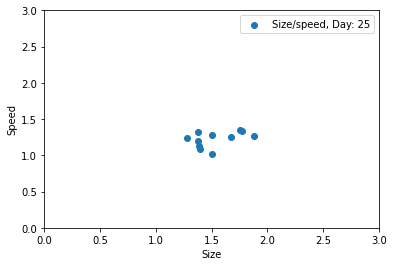

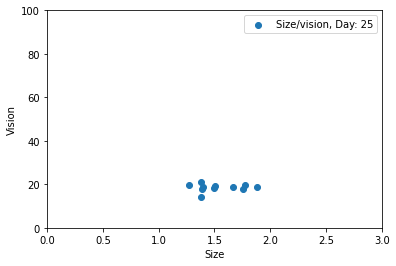

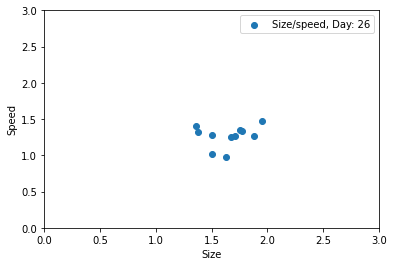

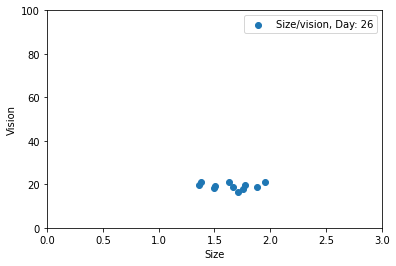

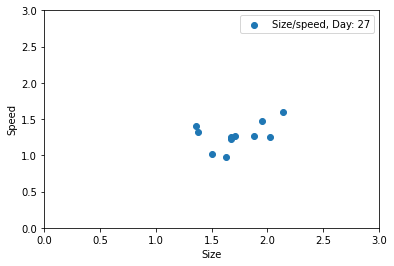

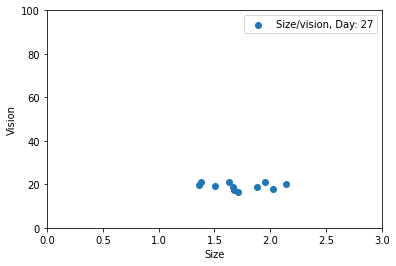

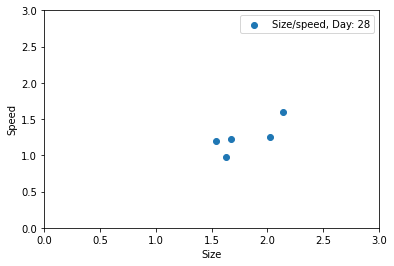

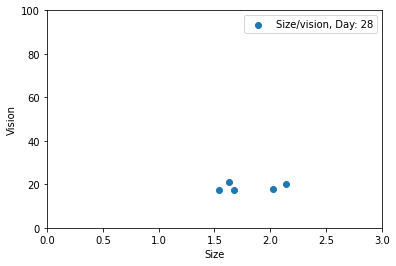

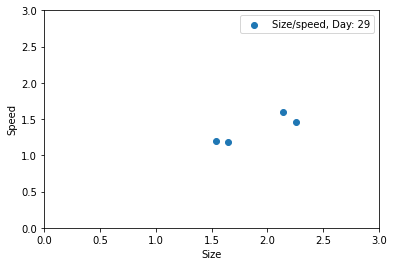

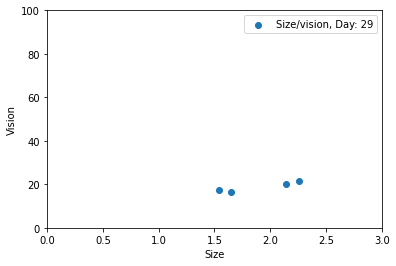

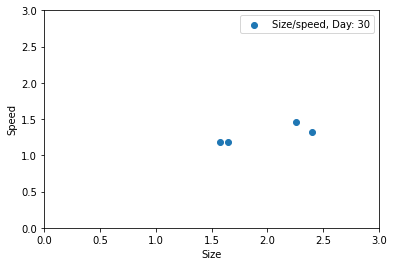

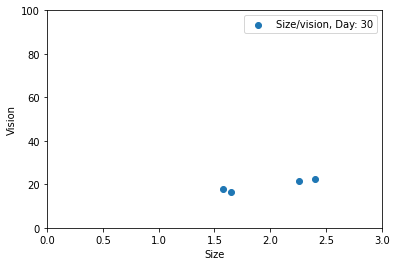

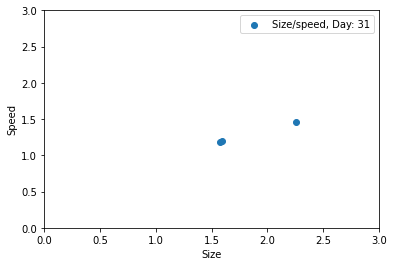

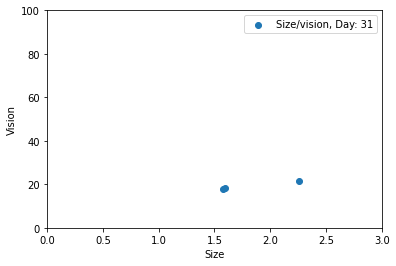

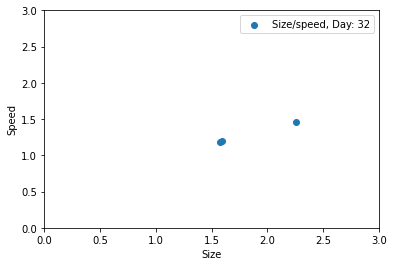

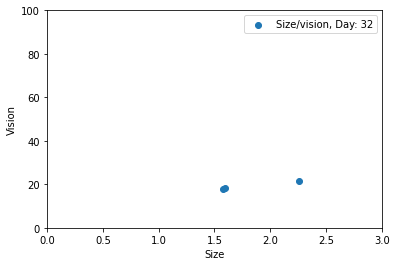

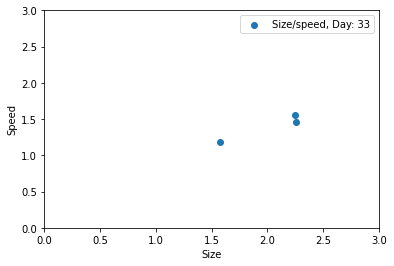

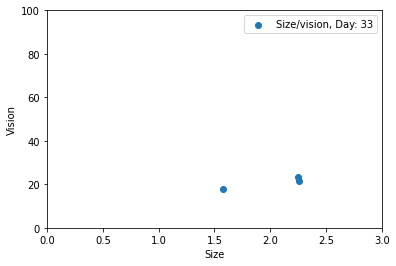

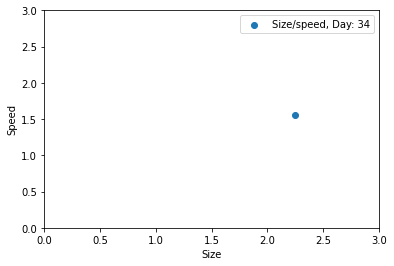

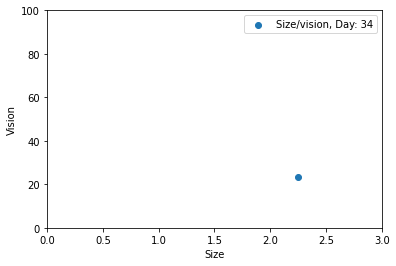

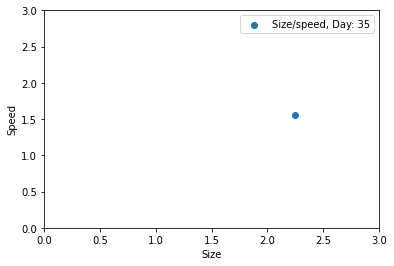

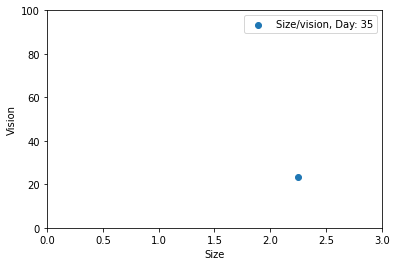

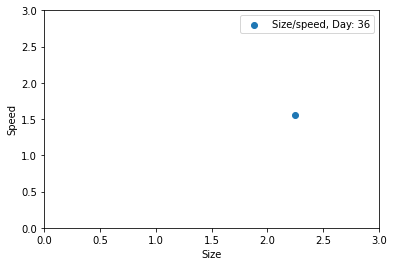

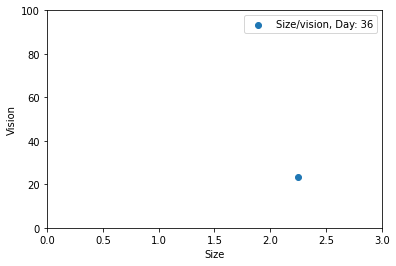

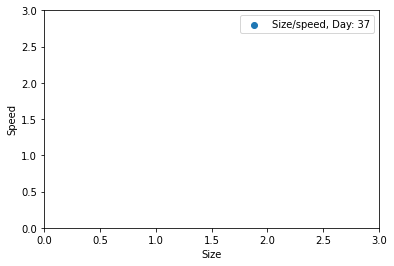

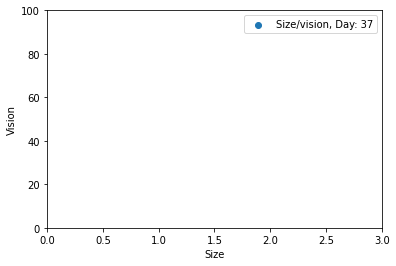

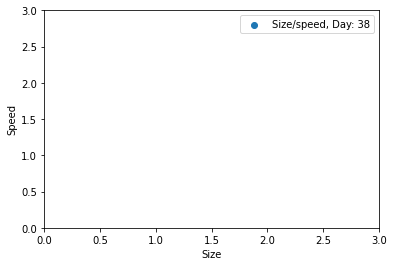

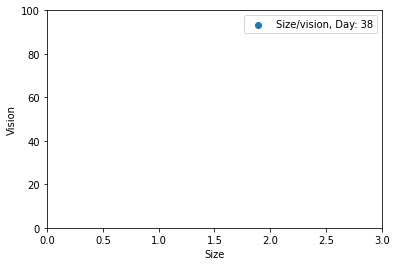

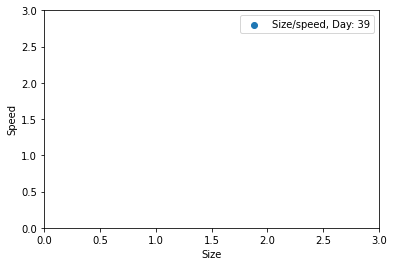

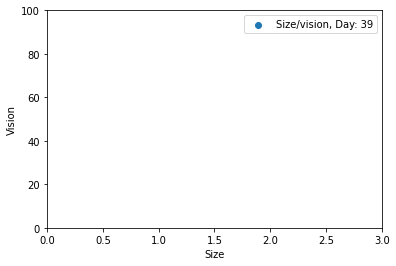

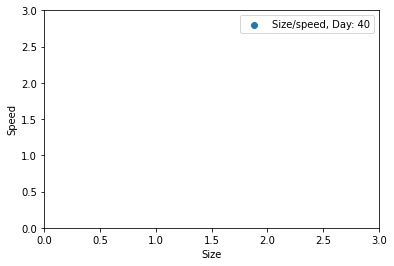

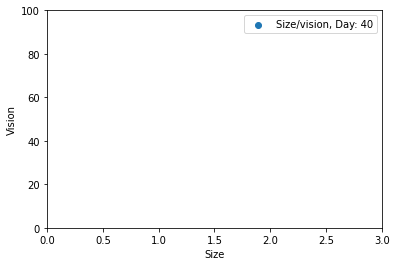

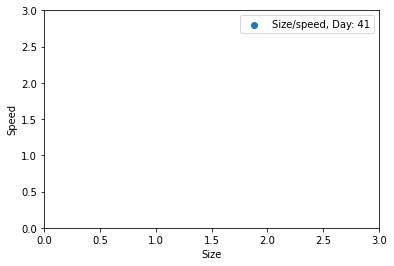

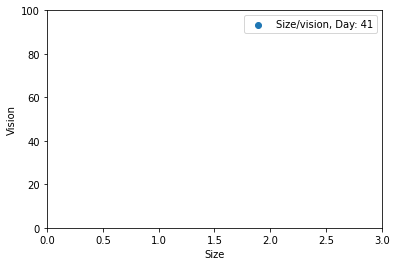

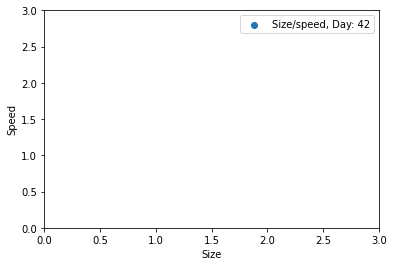

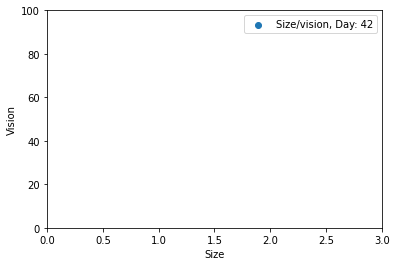

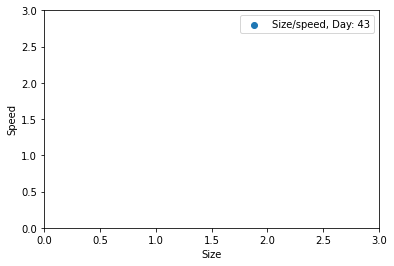

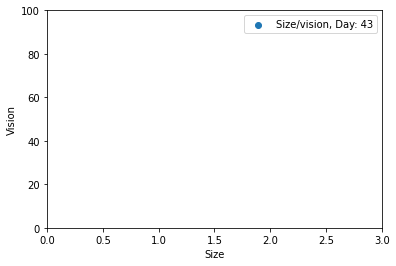

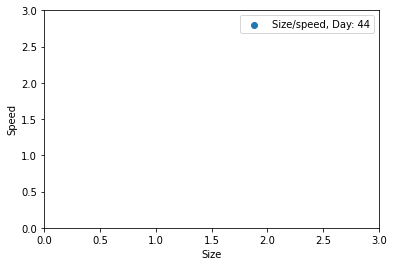

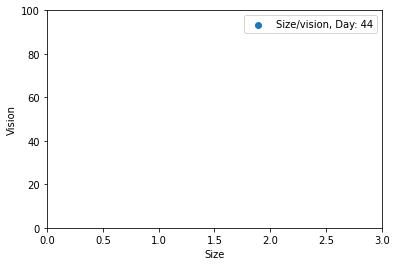

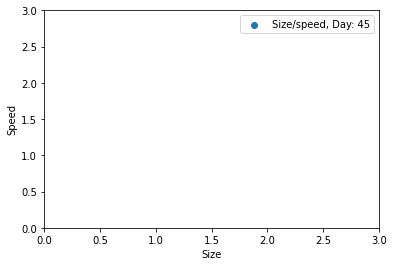

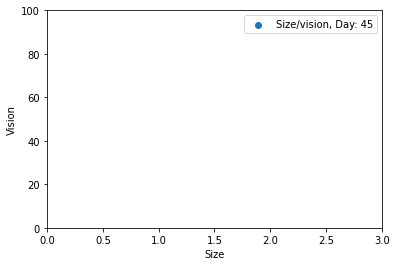

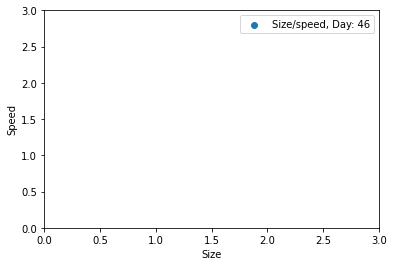

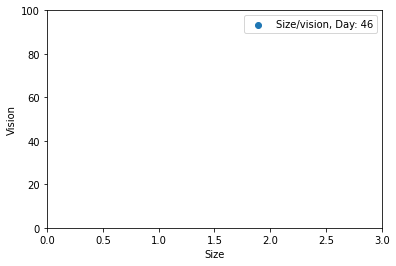

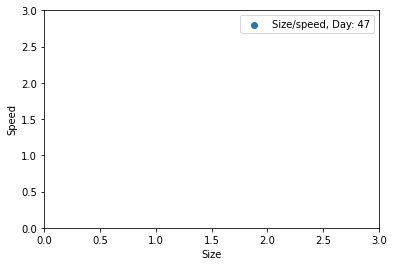

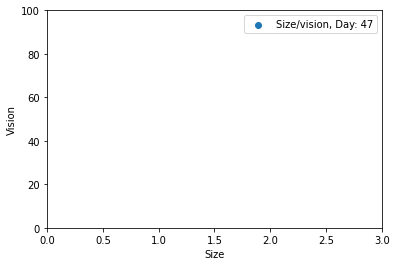

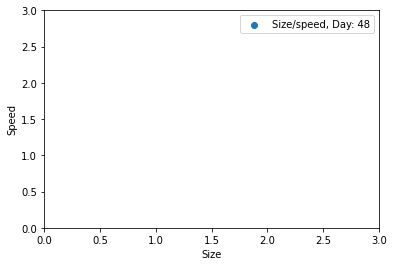

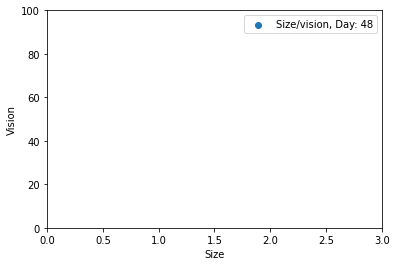

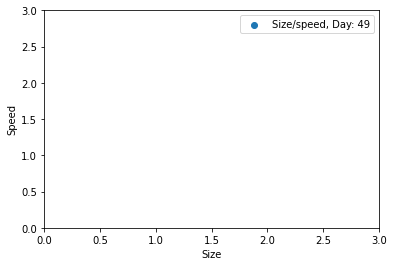

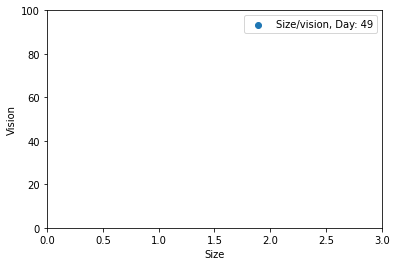

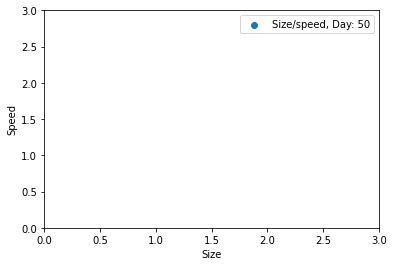

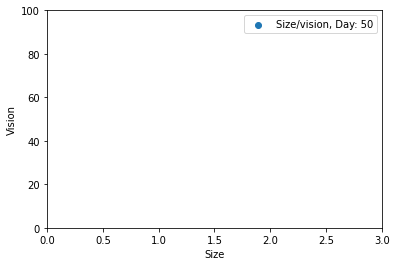

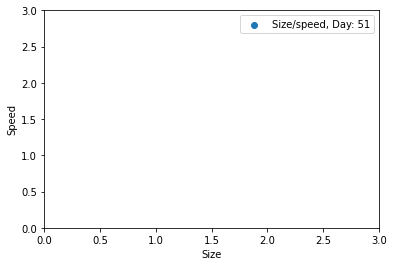

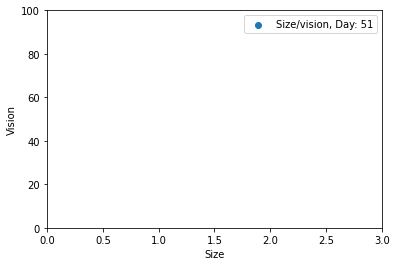

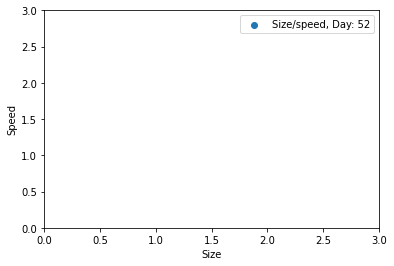

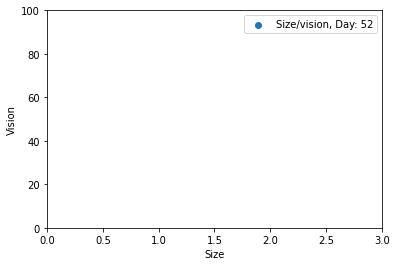

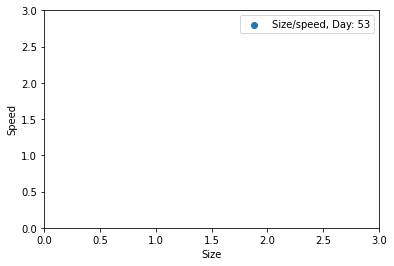

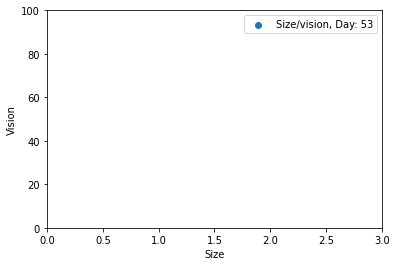

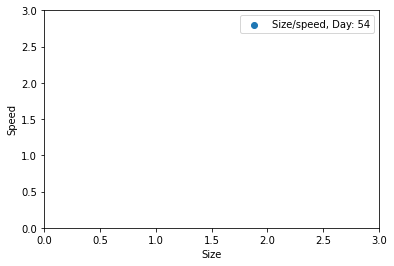

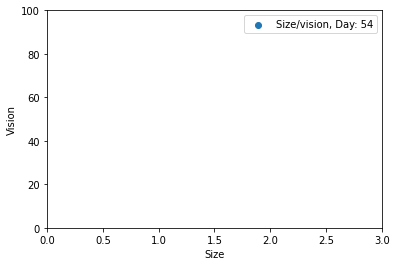

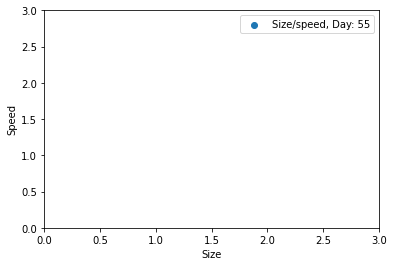

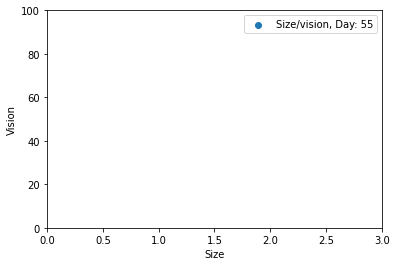

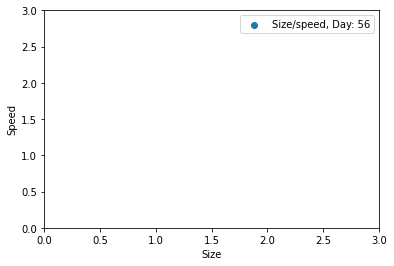

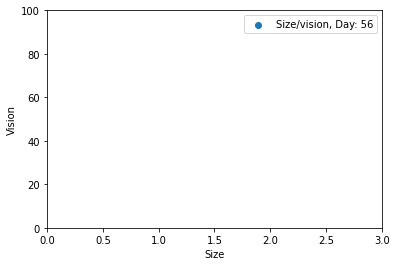

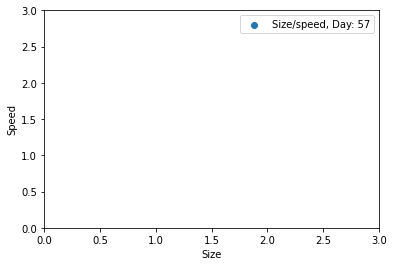

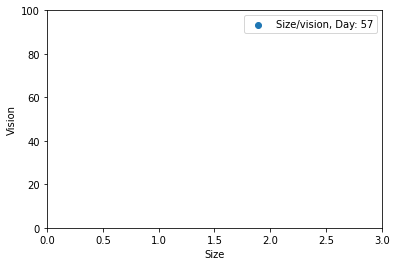

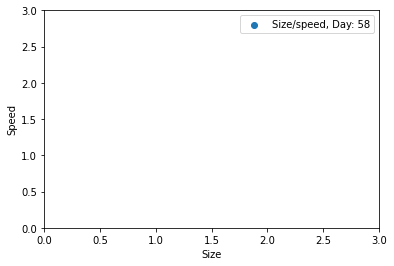

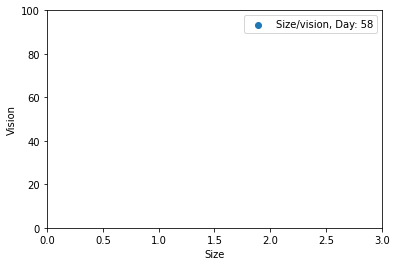

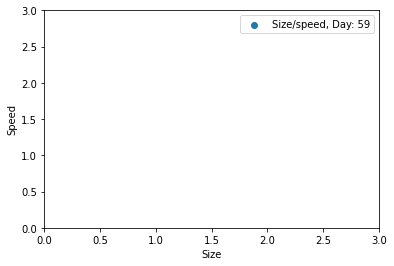

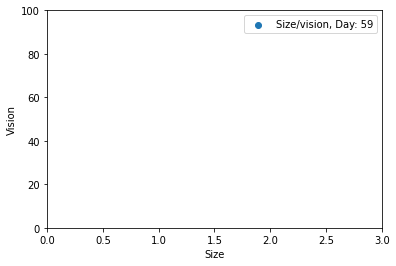

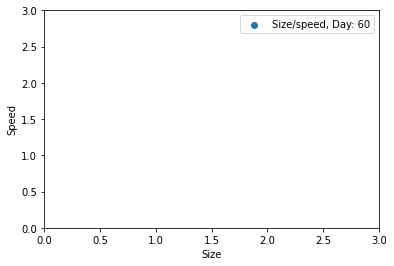

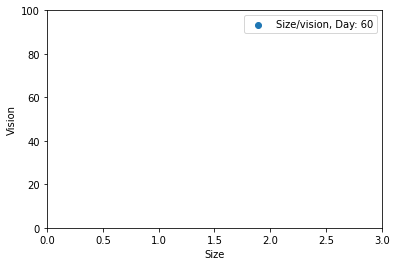

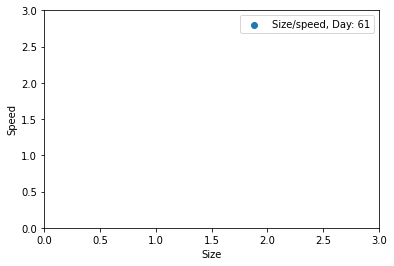

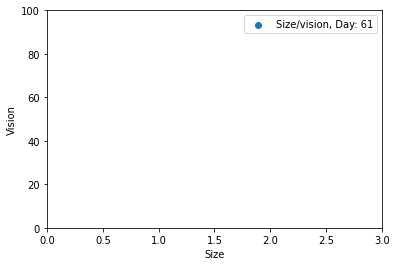

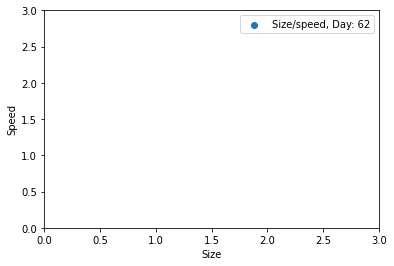

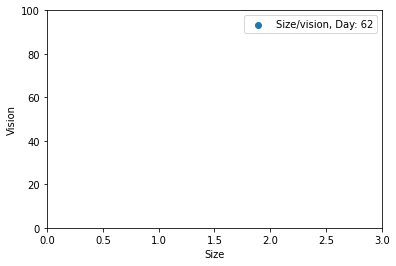

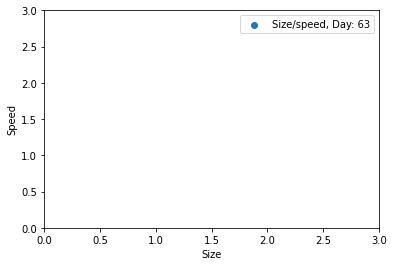

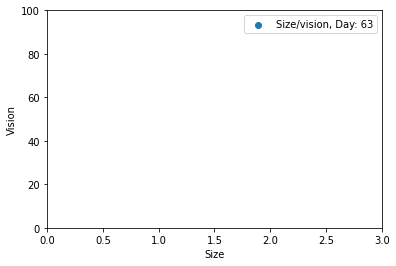

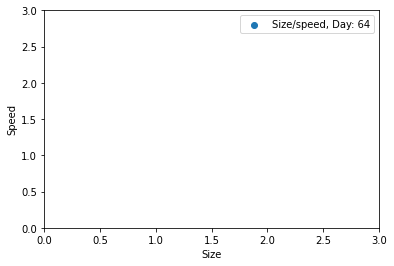

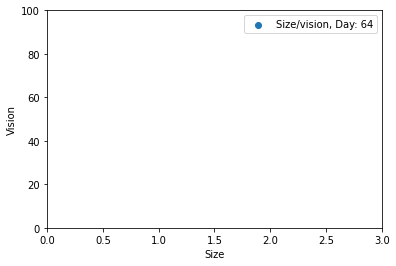

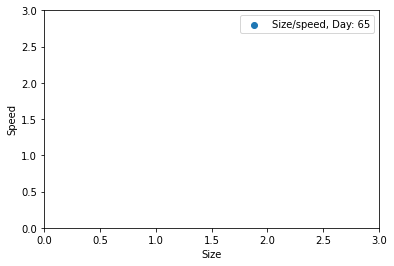

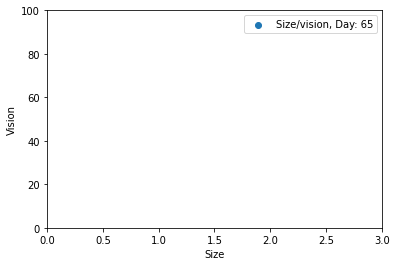

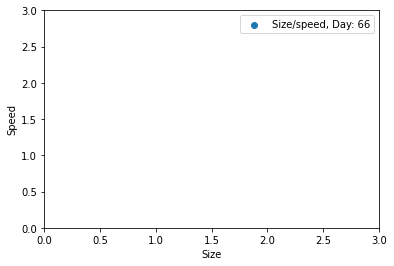

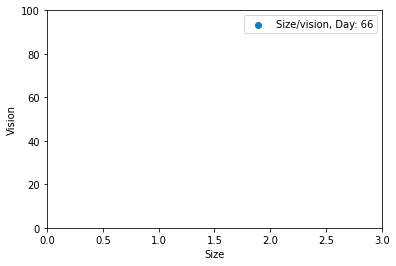

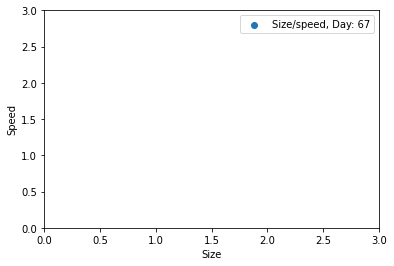

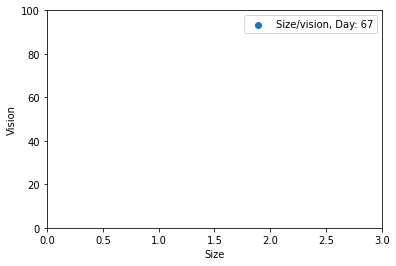

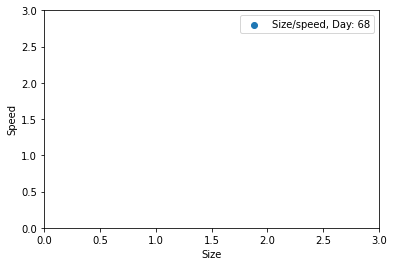

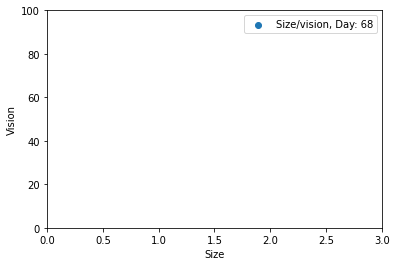

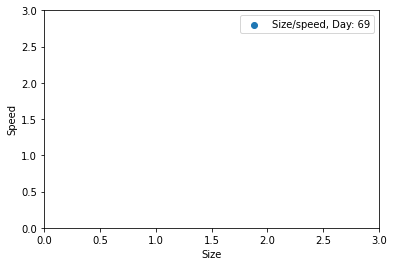

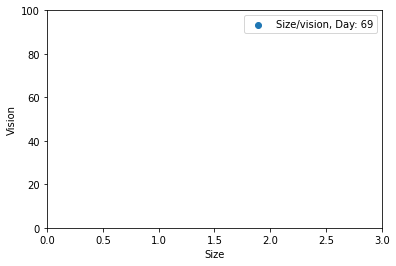

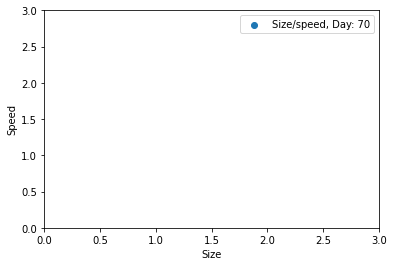

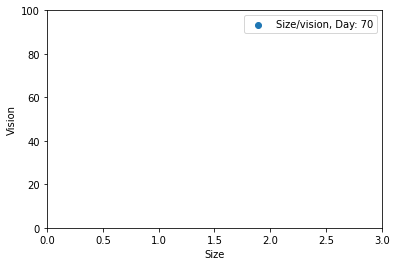

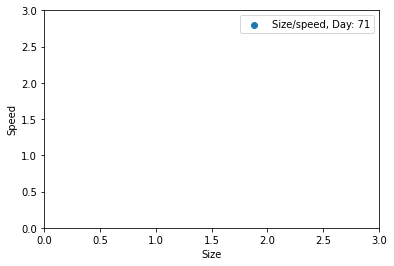

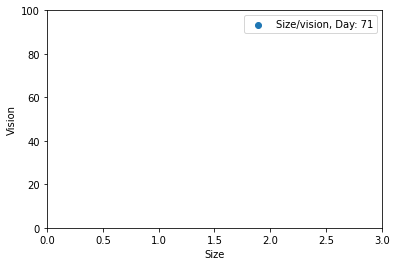

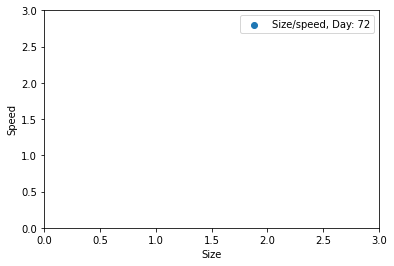

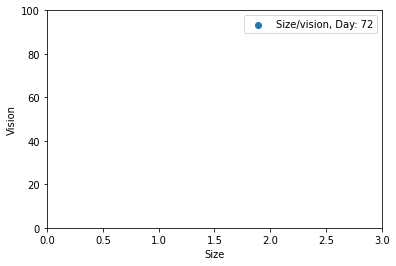

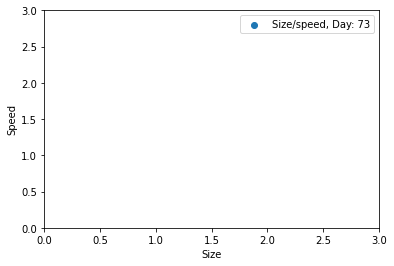

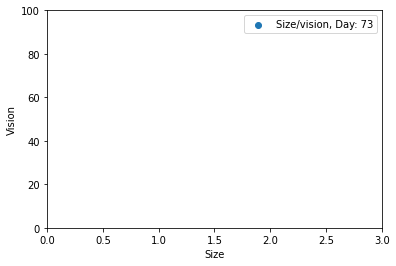

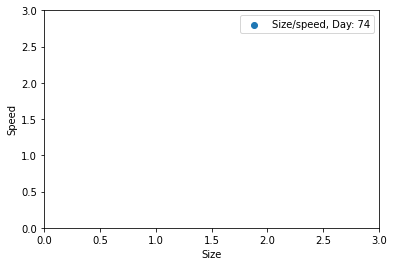

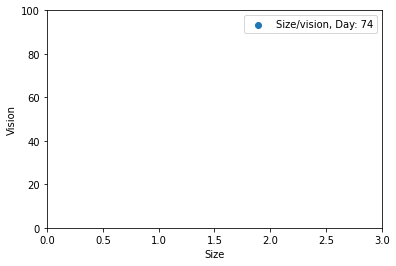

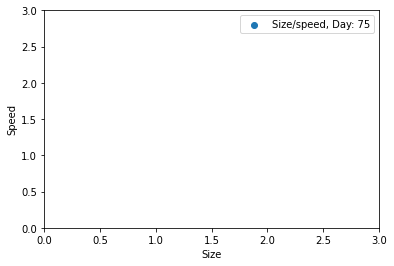

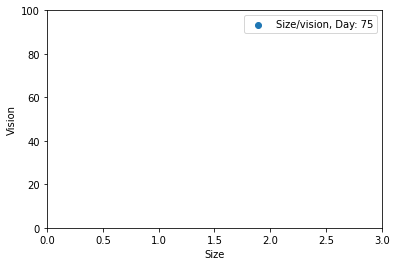

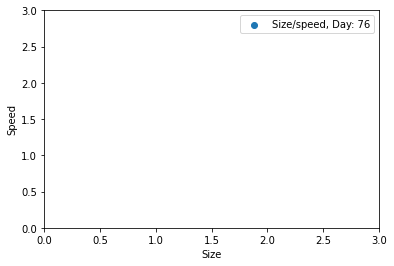

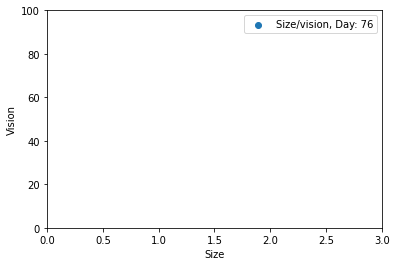

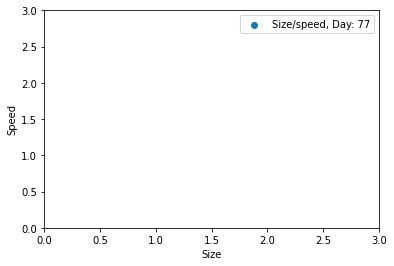

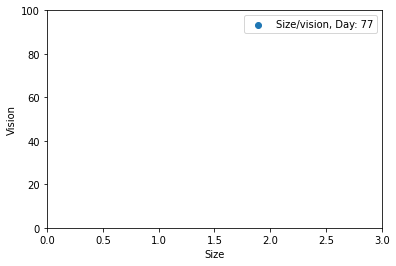

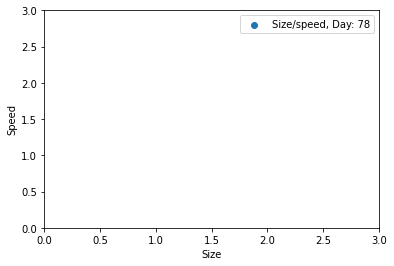

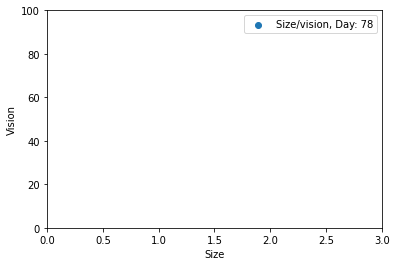

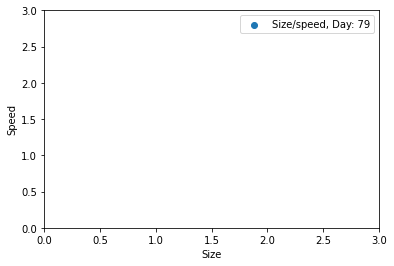

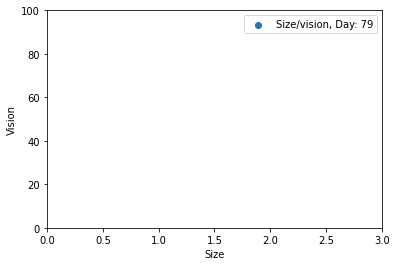

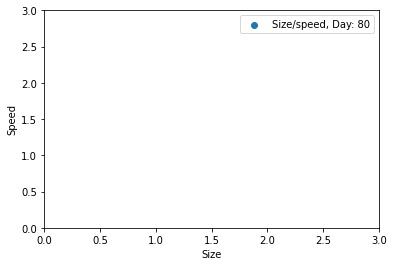

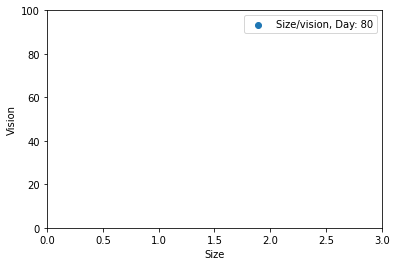

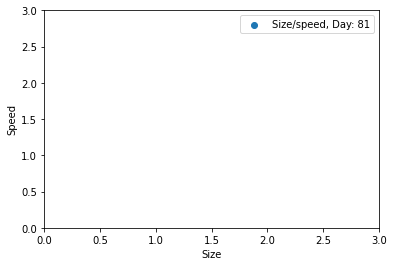

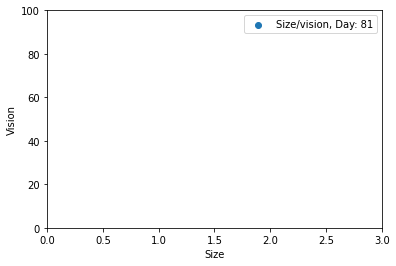

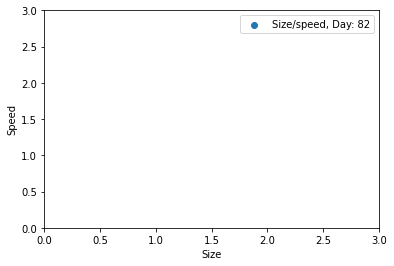

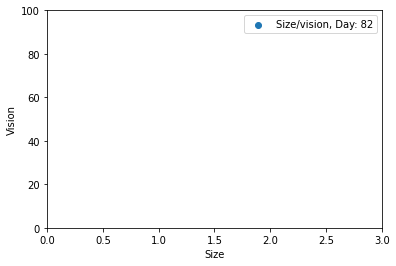

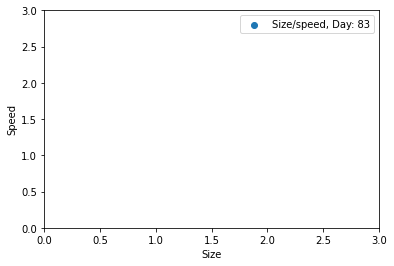

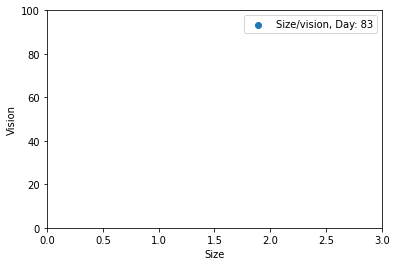

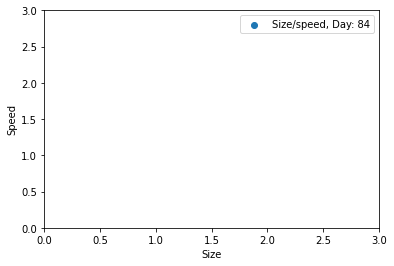

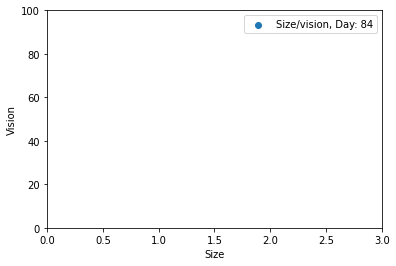

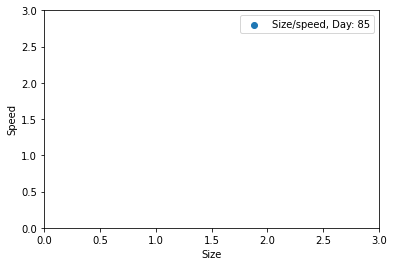

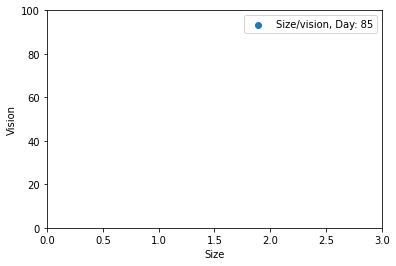

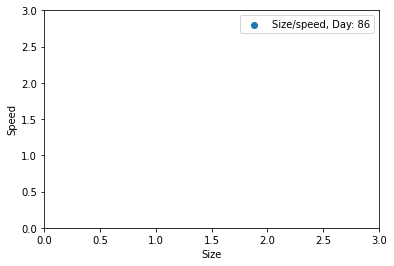

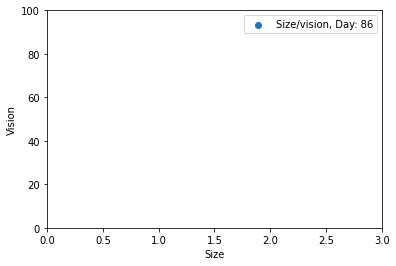

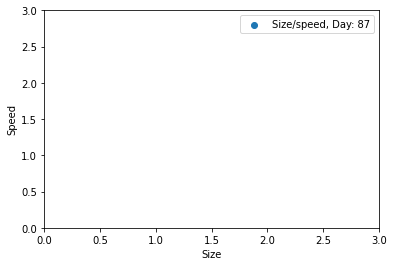

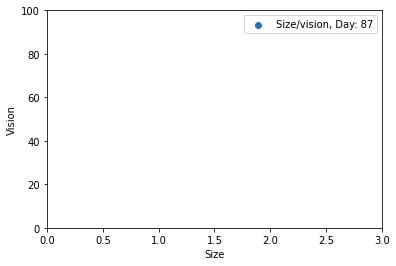

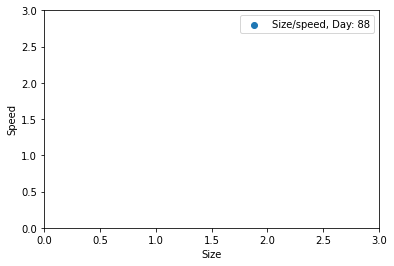

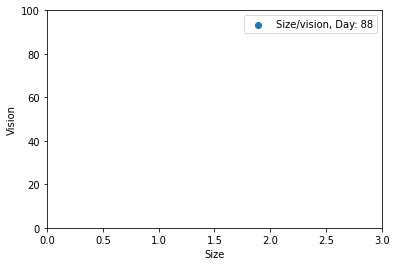

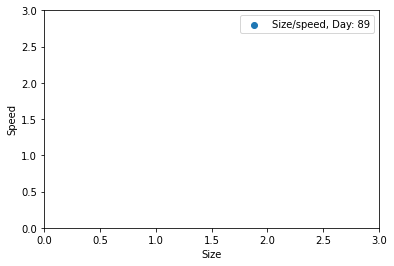

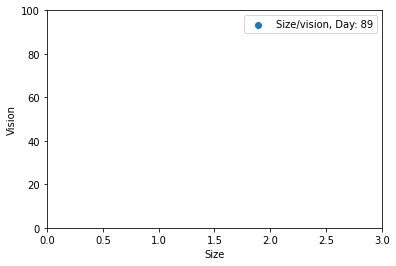

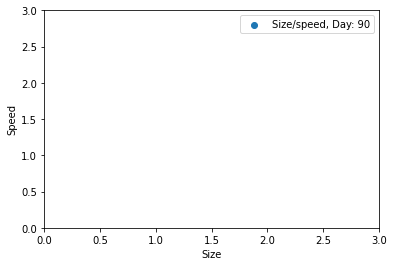

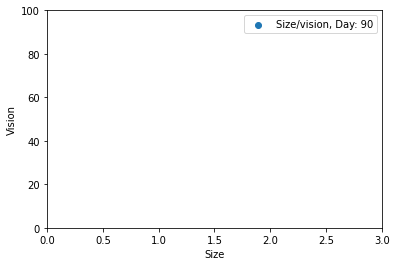

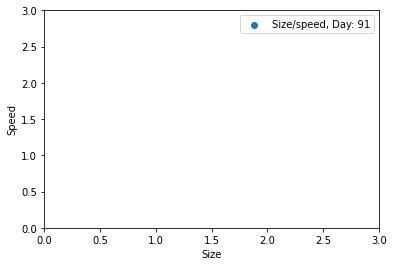

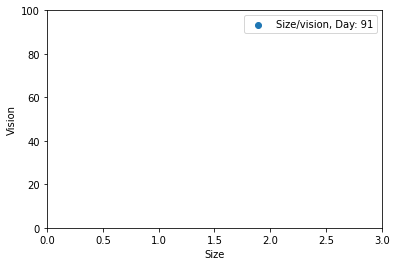

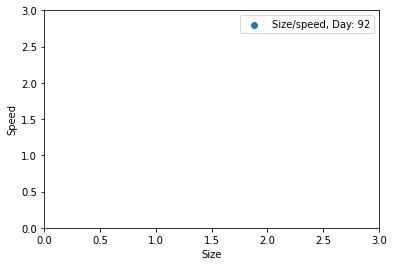

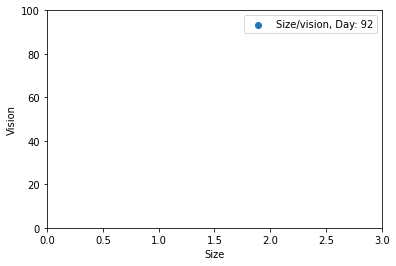

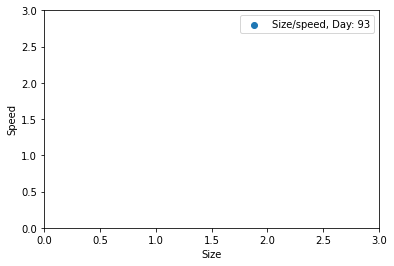

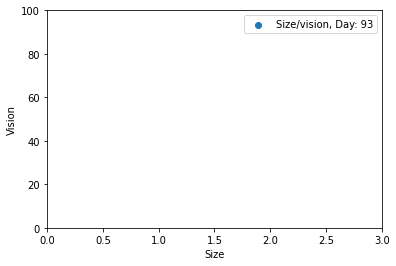

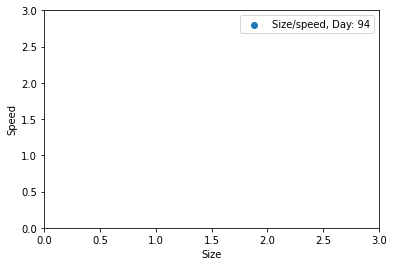

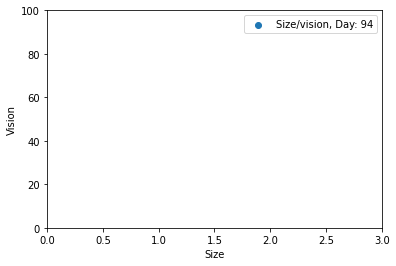

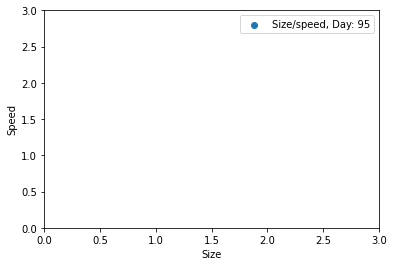

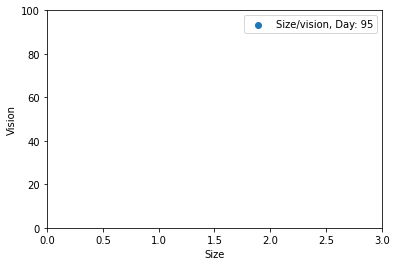

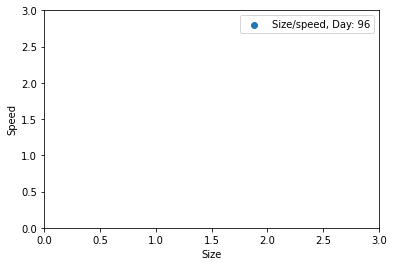

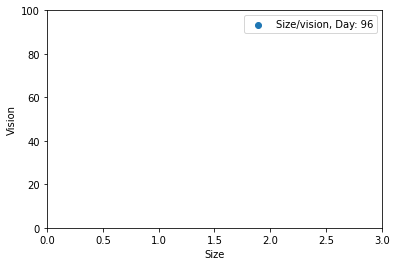

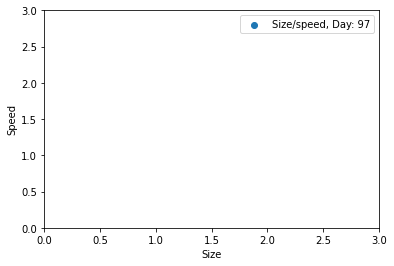

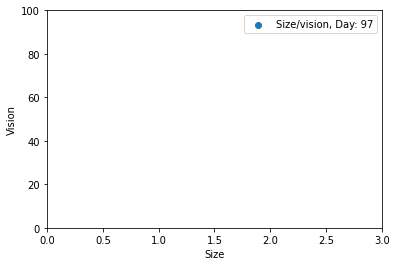

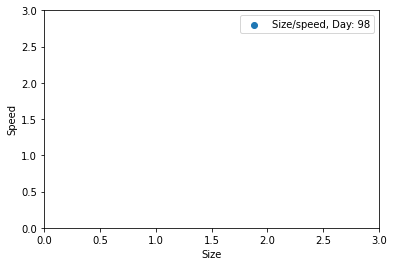

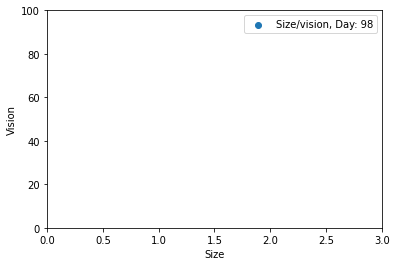

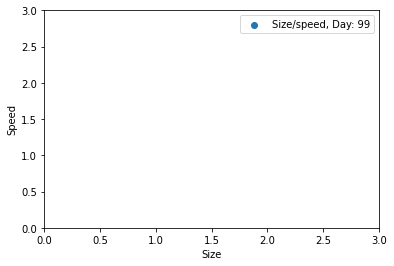

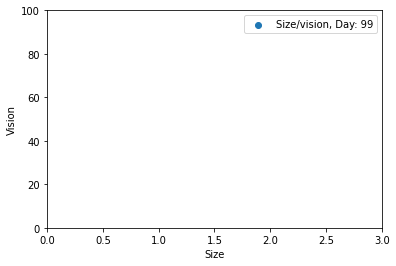

In [6]:
import matplotlib.pyplot as plt

days=range(0,100)
jpg_files_paths="plots/"
for day in days:
    plt.figure()
    plt.scatter(size[day],speed[day],label="Size/speed, Day: "+str(day))
    plt.xlabel("Size")
    plt.ylabel("Speed")
    plt.xlim(0,3)
    plt.ylim(0,3)
    plt.legend()
    if day<10:
        plt.savefig("plots/size_speed00"+str(day)+".jpg")
    elif day<100:
        plt.savefig("plots/size_speed0"+str(day)+".jpg")
    else:
        plt.savefig("plots/size_speed"+str(day)+".jpg")

    plt.figure()
    plt.scatter(size[day],vision[day],label="Size/vision, Day: "+str(day))
    plt.xlabel("Size")
    plt.ylabel("Vision")
    plt.xlim(0,3)
    plt.ylim(0,100)
    plt.legend()
    if day<10:
        plt.savefig("plots/size_vision00"+str(day)+".jpg")
    elif day<100:
        plt.savefig("plots/size_vision0"+str(day)+".jpg")
    else:
        plt.savefig("plots/size_vision"+str(day)+".jpg")



In [7]:
import glob
import imageio.v2 as imageio
max_days=days[-1]
images=[]
for image_path in sorted(glob.glob("plots/size_vision*.jpg")):
    images.append(imageio.imread(image_path))
imageio.mimsave("figures_for_report/"+run_name+"/size_vision_"+str(max_days)+".gif",images)
images=[]
for image_path in sorted(glob.glob("plots/size_speed*.jpg")):
    images.append(imageio.imread(image_path))
imageio.mimsave("figures_for_report/"+run_name+"/size_speed_"+str(max_days)+".gif",images)

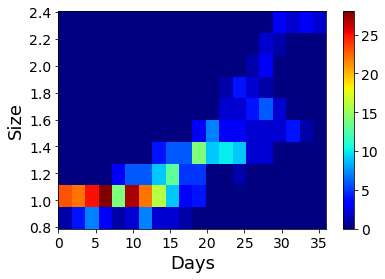

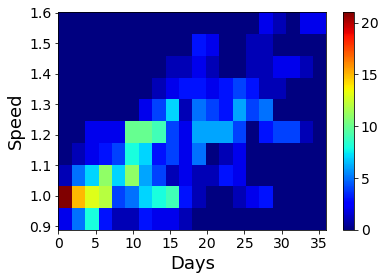

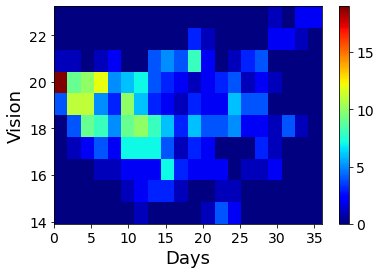

In [8]:
save=True
size_flatten=[]
speed_flatten=[]
vision_flatten=[]
days_flatten=[]
day=0
for size_arr,speed_arr,vision_arr in zip(size,speed,vision):
    for s,sp,v in zip(size_arr,speed_arr,vision_arr):
        size_flatten.append(s)
        speed_flatten.append(sp)
        vision_flatten.append(v)
        days_flatten.append(day)
    day +=1
fontsize_major=18
fontsize_minor=14
plt.figure()
plt.hist2d(days_flatten,size_flatten,bins=(20,10),cmap='jet')
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=fontsize_minor)
plt.xlabel("Days",fontsize=fontsize_major)
plt.ylabel("Size",fontsize=fontsize_major)
plt.xticks(fontsize=fontsize_minor)
plt.yticks(fontsize=fontsize_minor)
if save:
    plt.savefig("figures_for_report/"+run_name+"/size_hist2d.pdf",bbox_inches='tight')

plt.figure()
plt.hist2d(days_flatten,speed_flatten,bins=(20,10),cmap='jet')
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=fontsize_minor)
plt.xlabel("Days",fontsize=fontsize_major)
plt.ylabel("Speed",fontsize=fontsize_major)
plt.xticks(fontsize=fontsize_minor)
plt.yticks(fontsize=fontsize_minor)
if save:
    plt.savefig("figures_for_report/"+run_name+"/speed_hist2d.pdf",bbox_inches='tight')

plt.figure()
plt.hist2d(days_flatten,vision_flatten,bins=(20,10),cmap='jet')
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=fontsize_minor)
plt.xlabel("Days",fontsize=fontsize_major)
plt.ylabel("Vision",fontsize=fontsize_major)
plt.xticks(fontsize=fontsize_minor)
plt.yticks(fontsize=fontsize_minor)
if save:
    plt.savefig("figures_for_report/"+run_name+"/vision_hist2d.pdf",bbox_inches='tight')

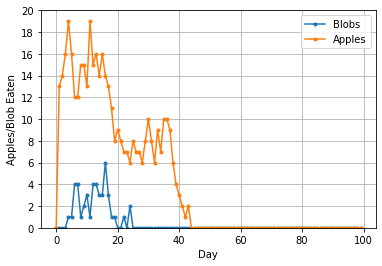

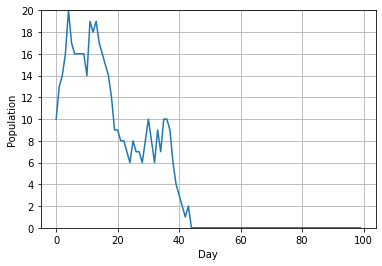

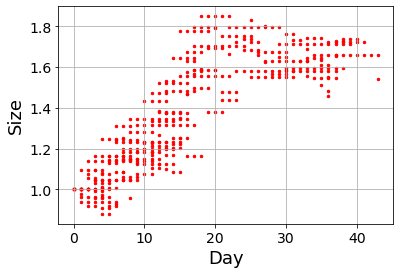

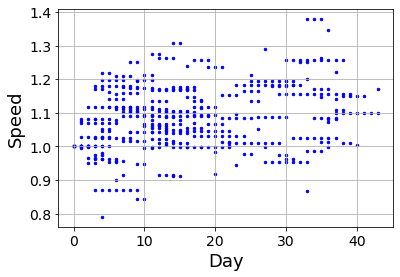

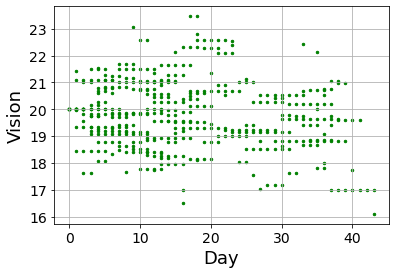

In [16]:
from matplotlib.ticker import MaxNLocator
save=True

fontsize_major=18
fontsize_minor=14
apples_eaten_per_day =[]
blobs_eaten_per_day =[]
for i in days:
    if i==0:
        apples_eaten_per_day.append(apples_eaten[i])
        blobs_eaten_per_day.append(blobs_eaten[i])
    else:
        apples_eaten_per_day.append(apples_eaten[i]-apples_eaten[i-1])
        blobs_eaten_per_day.append(blobs_eaten[i]-blobs_eaten[i-1])
plt.figure()
plt.xlabel("Day")
plt.ylabel("Apples/Blob Eaten")
plt.grid()
plt.yticks(range(-2,22,2))
plt.ylim(bottom=0)
plt.plot(days,blobs_eaten_per_day,label="Blobs",marker='.')
plt.plot(days,apples_eaten_per_day,label="Apples",marker='.')
plt.legend()
if save:
    plt.savefig("figures_for_report/"+run_name+"/blobs_apples_eaten.pdf")


days=range(0,100)
population = [len(x) for x in size]
plt.figure()
plt.xlabel("Day")
plt.ylabel("Population")
plt.grid()
plt.yticks(range(-2,22,2))
plt.ylim(bottom=0)
plt.plot(days,population)
if save:
    plt.savefig("figures_for_report/"+run_name+"/population.pdf")


plt.figure()
plt.xlabel("Day",fontsize=fontsize_major)
plt.ylabel("Size",fontsize=fontsize_major)
plt.xticks(fontsize=fontsize_minor)
plt.yticks(fontsize=fontsize_minor)
plt.grid()
for day,s in zip(days,size):
    plt.scatter([day]*len(s),s,c="r",s=6)
if save:
    plt.savefig("figures_for_report/"+run_name+"/size_hits.pdf",bbox_inches='tight')

plt.figure()
plt.xlabel("Day",fontsize=fontsize_major)
plt.ylabel("Speed",fontsize=fontsize_major)
plt.xticks(fontsize=fontsize_minor)
plt.yticks(fontsize=fontsize_minor)
plt.grid()
for day,s in zip(days,speed):
    plt.scatter([day]*len(s),s,c="b",s=6)
if save:
    plt.savefig("figures_for_report/"+run_name+"/speed_hits.pdf",bbox_inches='tight')

plt.figure()
plt.xlabel("Day",fontsize=fontsize_major)
plt.ylabel("Vision",fontsize=fontsize_major)
plt.xticks(fontsize=fontsize_minor)
plt.yticks(fontsize=fontsize_minor)
plt.grid()
for day,s in zip(days,vision):
    plt.scatter([day]*len(s),s,c="g",s=6)
if save:
    plt.savefig("figures_for_report/"+run_name+"/vision_hits.pdf",bbox_inches='tight')

In [ ]:
"""
Parameter Review:
    -Day: is 1000 iteration
    -start population: blubs: 10, apples 20
    -initial energy is 800
    -energy lose = 1 => every blob can spend 80% of the day way scorching for food before it is home gain otherwise it dies
    -each blob can eat blobs that half the size and avoid the blobs that double the size
    -the size increase only with mutation however it can be made as a function of food intake
    -vision range in 10 and it changes only with mutation
    -mutation is invitabley every generation, however it can be given a probability
    -initial configuration 10 blobs and 20 apples. Apples are constant and renewed every day
    - size is inversely proportionate to speed
    summary:
        each blob start from the boundary scorching for food and losses energy every time step
        if the blob get to eat one food item, then it ensures survival to the next day
        if the blob runs out of energy before getting food, it dies
        and it stop losing energy in this particular day. Thus, after eating one food item
        the blob continue walking freely for the second food item that ensures reproduction
        if the blob gets the second item, it goes home 
        in the next day, only blobs that got two items get replicated
        in the replication, the mutation occurs
"""
       
window = pygame.display.set_mode((500, 500))
world_width, world_height = window.get_size()
#pygame.display.set_caption("EcoSystem")
Time = pygame.time.Clock()

runTime_speed = 60
display_world = True


blob_world = EcoSystem(world_width, world_height)
iteration = 0
while True:
    #print(iteration)
    if display_world:
        i = 0
        
        for row in range(blob_world.eco_system.width_num):
            for col in range(blob_world.eco_system.height_num):
                pygame.draw.rect(window,blob_world.eco_system.color[i],
                                 (blob_world.eco_system.width_PortionSize * row,
                                 blob_world.eco_system.height_PortionSize * col,
                                 blob_world.eco_system.width_PortionSize,
                                 blob_world.eco_system.height_PortionSize))
                i += 1
                
        [ window.blit(obj.Image, (obj.x, obj.y)) for obj in blob_world.system_objects ]
        
       
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            pygame.quit()
        if event.type == pygame.KEYDOWN:
            if event.key == pygame.K_q:
                pygame.quit()
    
                
                
    blob_world.update(iteration)
    Day = "Day: "+ f"{int(iteration/1000 + 1)}"
    pygame.display.set_caption(Day)
    pygame.display.update()
    Time.tick(runTime_speed)
    iteration += 1